# Road Traffic Accident Severity Analysis Using Imbalanced and Explainable Machine Learning
Work developed by :
- Rodrigo Taveira, UP202206425

# Introduction
Road traffic accidents represent a major societal and economic challenge, particularly when severe accidents result in injuries or fatalities. Understanding the factors associated with accident severity is essential to support data-driven road safety planning and targeted interventions.

This notebook explores the prediction of accident severity using the US Accidents dataset. The analysis focuses on identifying temporal, environmental, and infrastructural patterns associated with severe accidents, while explicitly addressing the strong class imbalance present in the data. Multiple machine learning models are evaluated, including baseline approaches and imbalance-aware strategies.

In addition to predictive performance, explainability techniques such as SHAP and LIME are applied to interpret model decisions and provide insights into the factors contributing to severe accident predictions.


### Library Dependencies

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import math
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from lime.lime_tabular import LimeTabularExplainer
from IPython.display import HTML, display
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE


## Data Understanding and Initial Exploration
Before developing any predictive model, it is essential to understand the structure, quality, and behaviour of the data. In this phase, the road accident dataset is explored to identify relevant patterns, relationships, and potential sources of bias that may influence accident severity predictions. Through descriptive statistics and visual analysis, we aim to gain an initial understanding of how temporal factors (such as hour of day, day of week, and seasonality), environmental conditions, and road infrastructure characteristics relate to severe and non-severe accidents. This exploratory stage provides the foundation for informed modelling decisions, ensuring that subsequent analyses are guided by a clear understanding of the data and its underlying dynamics.


In [55]:
df = pd.read_csv("US_Accidents_March23.csv")

In [56]:
df.shape
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 11  Street                 object 
 12  City                   object 
 13  County                 object 
 14  State                  object 
 15  Zipcode                object 
 16  Country                object 
 17  Timezone               object 
 18  Airport_Code           object 
 19  Weather_Timestamp      object 
 20  Temperature(F)         float64
 21  Wind_Chill(F)          float64
 22  Humidity(%)       

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,7.728394e+06,7.728394e+06,7.728394e+06,4.325632e+06,4.325632e+06,7.728394e+06,7.564541e+06,5.729375e+06,7.554250e+06,7.587715e+06,7.551296e+06,7.157161e+06,5.524808e+06
mean,2.212384e+00,3.620119e+01,-9.470255e+01,3.626183e+01,-9.572557e+01,5.618423e-01,6.166329e+01,5.825105e+01,6.483104e+01,2.953899e+01,9.090376e+00,7.685490e+00,8.407210e-03
std,4.875313e-01,5.076079e+00,1.739176e+01,5.272905e+00,1.810793e+01,1.776811e+00,1.901365e+01,2.238983e+01,2.282097e+01,1.006190e+00,2.688316e+00,5.424983e+00,1.102246e-01
min,1.000000e+00,2.455480e+01,-1.246238e+02,2.456601e+01,-1.245457e+02,0.000000e+00,-8.900000e+01,-8.900000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,3.339963e+01,-1.172194e+02,3.346207e+01,-1.177543e+02,0.000000e+00,4.900000e+01,4.300000e+01,4.800000e+01,2.937000e+01,1.000000e+01,4.600000e+00,0.000000e+00
50%,2.000000e+00,3.582397e+01,-8.776662e+01,3.618349e+01,-8.802789e+01,3.000000e-02,6.400000e+01,6.200000e+01,6.700000e+01,2.986000e+01,1.000000e+01,7.000000e+00,0.000000e+00
75%,2.000000e+00,4.008496e+01,-8.035368e+01,4.017892e+01,-8.024709e+01,4.640000e-01,7.600000e+01,7.500000e+01,8.400000e+01,3.003000e+01,1.000000e+01,1.040000e+01,0.000000e+00
max,4.000000e+00,4.900220e+01,-6.711317e+01,4.907500e+01,-6.710924e+01,4.417500e+02,2.070000e+02,2.070000e+02,1.000000e+02,5.863000e+01,1.400000e+02,1.087000e+03,3.647000e+01


In [57]:
df["Severity"].value_counts()

Severity
2    6156981
3    1299337
4     204710
1      67366
Name: count, dtype: int64

### Target Variable Definition

Accident severity in the original dataset is represented as an ordinal variable with multiple levels. In order to frame the problem as a binary classification task and focus on the identification of severe accidents, the original severity scale is transformed into a binary target variable.

Specifically, accidents with severity greater than or equal to 3 are labeled as severe, while accidents with lower severity levels are labeled as non-severe. This formulation aligns with the objective of prioritizing the detection of high-risk accidents and facilitates the evaluation of imbalance-aware classification models.

In [58]:
df["Severity_binary"] = df["Severity"].apply(lambda x: 1 if x >= 3 else 0)
df = df.drop(columns=["Severity"])
df["Severity_binary"].value_counts()


Severity_binary
0    6224347
1    1504047
Name: count, dtype: int64

The target variable exhibits a strong class imbalance, with severe accidents representing a substantially smaller proportion of the dataset. This imbalance motivates the use of imbalance-aware modeling strategies and evaluation metrics beyond overall accuracy.


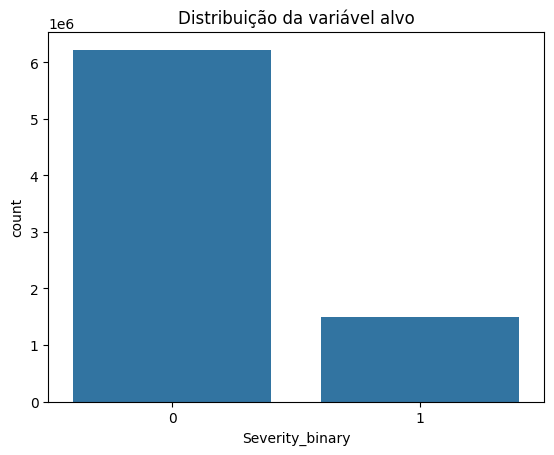

In [59]:
sns.countplot(x="Severity_binary", data=df)
plt.title("Distribuição da variável alvo")
plt.show()


In [60]:
df.columns

Index(['ID', 'Source', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City',
       'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code',
       'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight', 'Severity_binary'],
      dtype='object')

To better understand the scale, distribution, and variability of the numerical features, each numeric variable is examined individually using distribution plots.


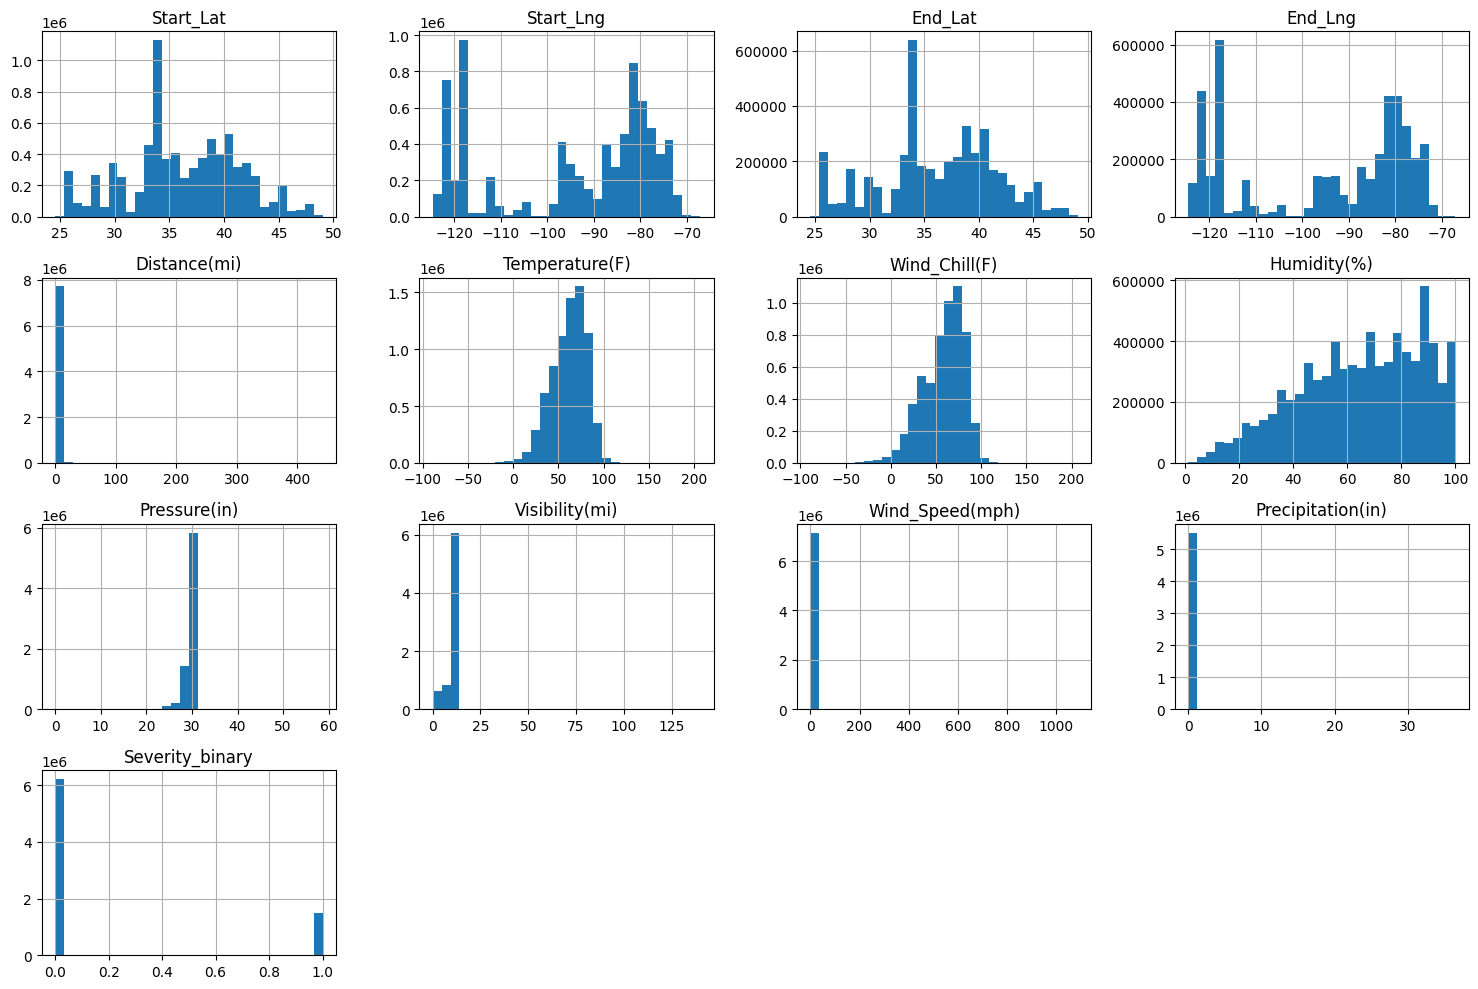

In [61]:
df.select_dtypes(include='number').hist(
    figsize=(15,10),
    bins=30
)
plt.tight_layout()
plt.show()


To assess linear relationships and potential multicollinearity among numerical variables, a correlation analysis was performed.


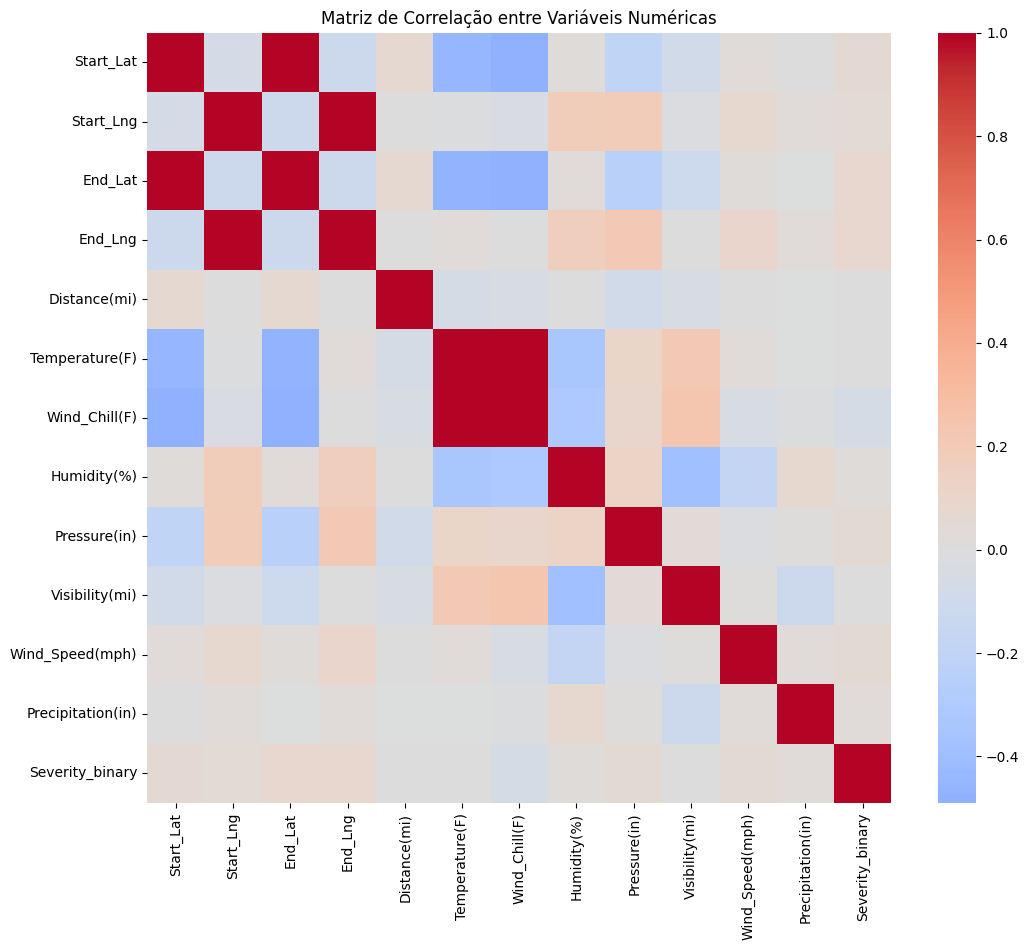

In [62]:
num_df = df.select_dtypes(include='number')

corr = num_df.corr()

plt.figure(figsize=(12,10))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    annot=False
)
plt.title("Matriz de Correlação entre Variáveis Numéricas")
plt.show()


The correlation matrix indicates that most numerical features exhibit weak linear relationships with each other and with the target variable. This suggests limited multicollinearity and supports the use of non-linear models capable of capturing complex interactions between variables.


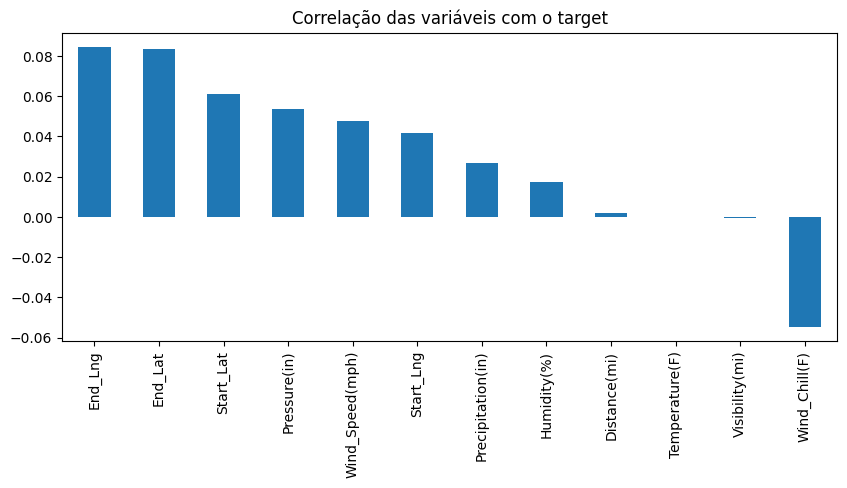

In [63]:
corr_target = corr["Severity_binary"].sort_values(ascending=False)
corr_target
corr_target.drop("Severity_binary").plot(
    kind='bar',
    figsize=(10,4),
    title="Correlação das variáveis com o target"
)
plt.show()

To reduce dimensionality and avoid data leakage or overly specific information, columns related to identification, redundant temporal data, detailed location descriptors, free-text fields, and low-relevance points of interest were removed from the dataset.


In [64]:
cols_to_drop = [
    # Identificação / metadata
    "ID", "Source", "Country", "Timezone",

    # Informação futura ou redundante
    "End_Time", "Weather_Timestamp",

    # Localização demasiado específica
    "Street", "City", "County", "Zipcode",
    "Start_Lat", "Start_Lng", "End_Lat", "End_Lng",

    # Texto livre
    "Description", "Wind_Chill(F)", "Wind_Direction",

    # Colunas pouco claras / indiretas
    "Distance(mi)", "Airport_Code",

    # POIs menos relevantes (para já)
    "Amenity", "Station", "Turning_Loop",
    "Traffic_Calming", "No_Exit", "Give_Way", "Railway",

    # Twilights redundantes (ficamos só com Sunrise_Sunset)
    "Civil_Twilight", "Nautical_Twilight", "Astronomical_Twilight",
]

df = df.drop(columns=cols_to_drop)


Temporal information was extracted from the accident start time by deriving the hour of day, day of week, and month, allowing the model to capture daily, weekly, and seasonal patterns in accident severity.


In [65]:
df["Start_Time"] = pd.to_datetime(df["Start_Time"], errors="coerce")
df["start_hour"] = df["Start_Time"].dt.hour
df["start_dayofweek"] = df["Start_Time"].dt.dayofweek  # 0=Mon
df["start_month"] = df["Start_Time"].dt.month
df = df.drop(columns=["Start_Time"])


Binary infrastructure-related features were standardized by converting missing values to false and encoding them as numerical indicators, ensuring consistent representation of road characteristics.


In [66]:
bool_cols = ["Bump", "Crossing", "Junction", "Roundabout", "Stop", "Traffic_Signal"]
for c in bool_cols:
    df[c] = df[c].fillna(False).astype("int8")

## Exploratory Data Analysis

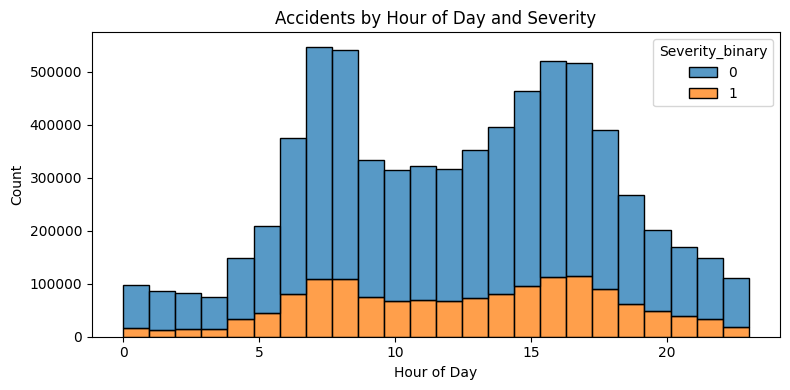

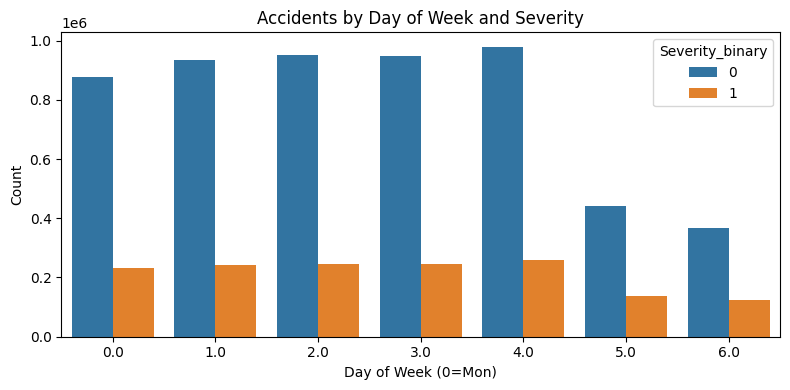

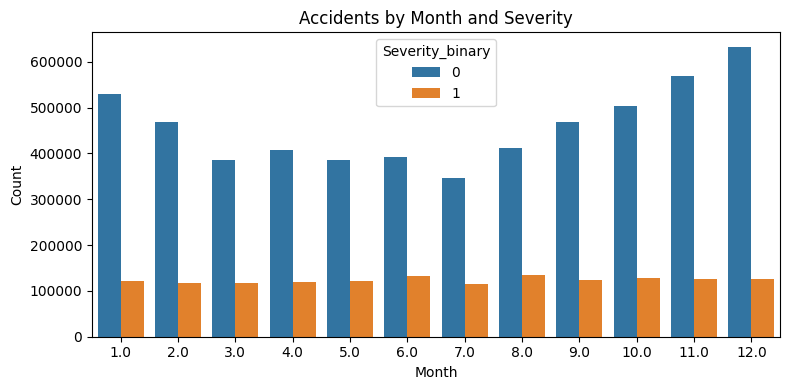

In [67]:
plt.figure(figsize=(8,4))
sns.histplot(
    data=df,
    x="start_hour",
    hue="Severity_binary",
    bins=24,
    multiple="stack"
)
plt.title("Accidents by Hour of Day and Severity")
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



plt.figure(figsize=(8,4))
sns.countplot(
    x="start_dayofweek",
    hue="Severity_binary",
    data=df
)
plt.title("Accidents by Day of Week and Severity")
plt.xlabel("Day of Week (0=Mon)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



plt.figure(figsize=(8,4))
sns.countplot(
    x="start_month",
    hue="Severity_binary",
    data=df
)
plt.title("Accidents by Month and Severity")
plt.xlabel("Month")
plt.ylabel("Count")
plt.tight_layout()
plt.show()




These plots reveal clear temporal patterns in accident occurrence, with higher frequencies during commuting hours, on weekdays, and noticeable seasonal variation across months, supporting the relevance of temporal features in accident severity analysis.


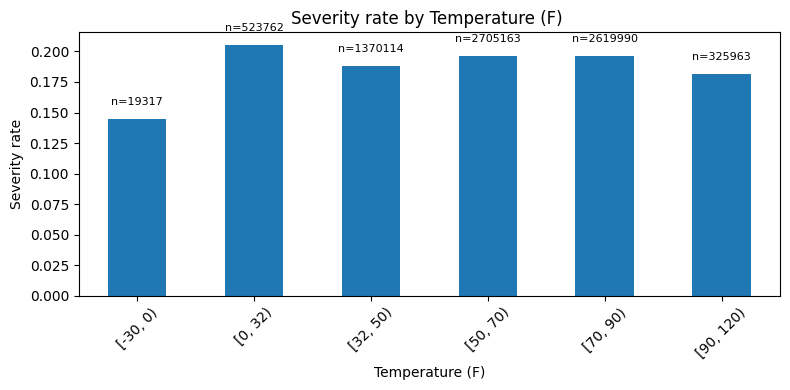

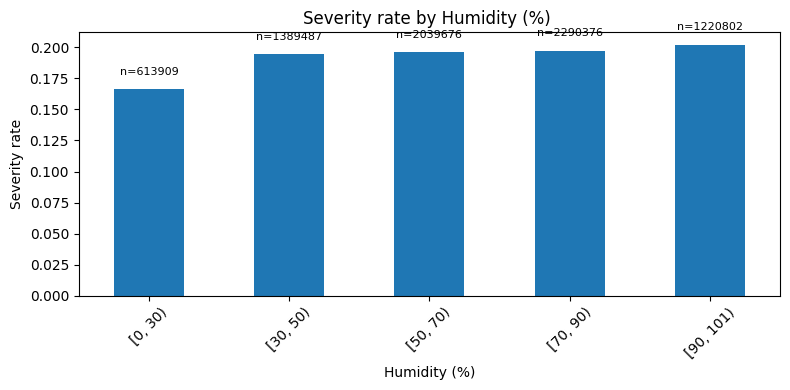

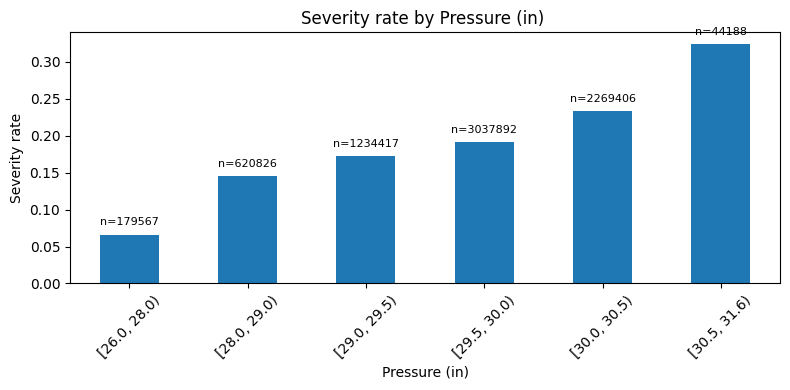

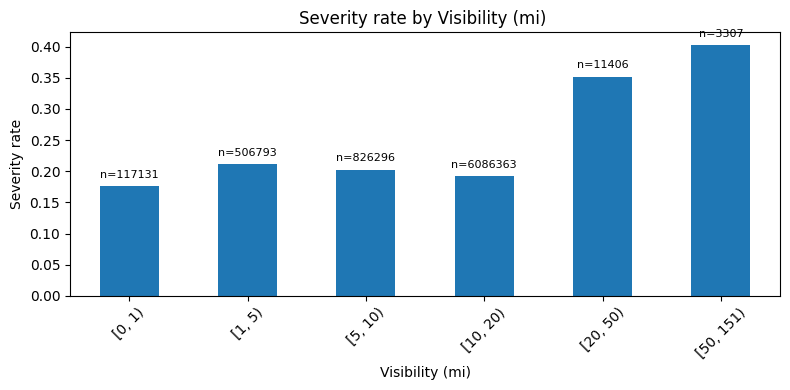

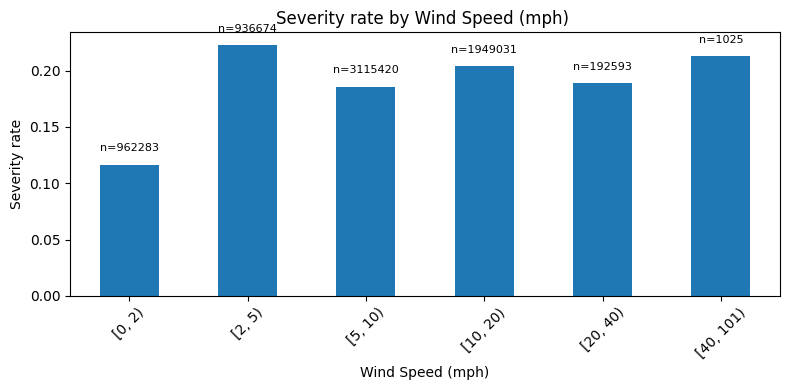

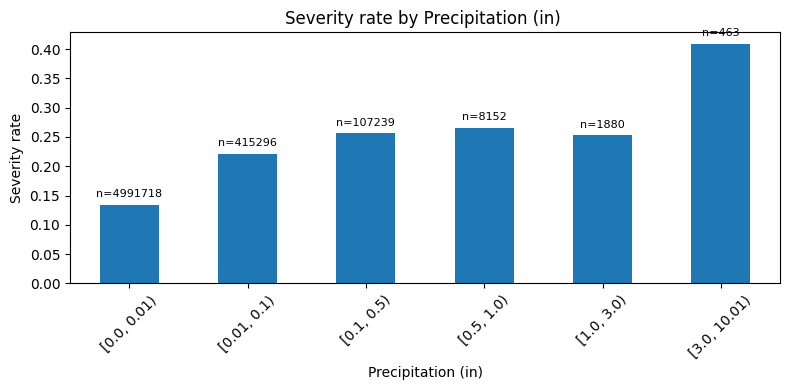

In [ ]:
def severity_rate_by_bins(df, feature, bins, xlabel=None):
    df_tmp = df[[feature, "Severity_binary"]].dropna().copy()
    df_tmp["bin"] = pd.cut(df_tmp[feature], bins=bins, include_lowest=True, right=False)

    rate = df_tmp.groupby("bin", observed=False)["Severity_binary"].mean()
    count = df_tmp.groupby("bin", observed=False)["Severity_binary"].size()

    ax = rate.plot(kind="bar", figsize=(8,4))
    ax.set_title(f"Severity rate by {xlabel or feature} ")
    ax.set_xlabel(xlabel or feature)
    ax.set_ylabel("Severity rate")
    ax.tick_params(axis="x", rotation=45)

    for i, (r, n) in enumerate(zip(rate.values, count.values)):
        if not np.isnan(r):
            ax.text(i, r + 0.01, f"n={int(n)}", ha="center", va="bottom", fontsize=8)

    plt.tight_layout()
    plt.show()
    
bin_specs = {
    "Temperature(F)":     {"bins": [-30, 0, 32, 50, 70, 90, 120],          "label": "Temperature (F)"},
    "Humidity(%)":        {"bins": [0, 30, 50, 70, 90, 101],               "label": "Humidity (%)"},
    "Pressure(in)":       {"bins": [26, 28, 29, 29.5, 30, 30.5, 31.6],     "label": "Pressure (in)"},
    "Visibility(mi)":     {"bins": [0, 1, 5, 10, 20, 50, 151],             "label": "Visibility (mi)"},
    "Wind_Speed(mph)":    {"bins": [0, 2, 5, 10, 20, 40, 101],             "label": "Wind Speed (mph)"},
    "Precipitation(in)":  {"bins": [0, 0.01, 0.1, 0.5, 1, 3, 10.01],       "label": "Precipitation (in)"},
}

for feat, spec in bin_specs.items():
    if feat in df.columns:
        severity_rate_by_bins(df, feat, spec["bins"], spec["label"])
    else:
        print(f"[Aviso] Coluna '{feat}' não existe no df.")



The analysis of environmental variables shows clear trends in accident severity. Higher precipitation levels, extreme visibility conditions, and higher atmospheric pressure are associated with increased severity rates, while temperature, wind speeds and humidity exhibit more moderate but consistent variations.


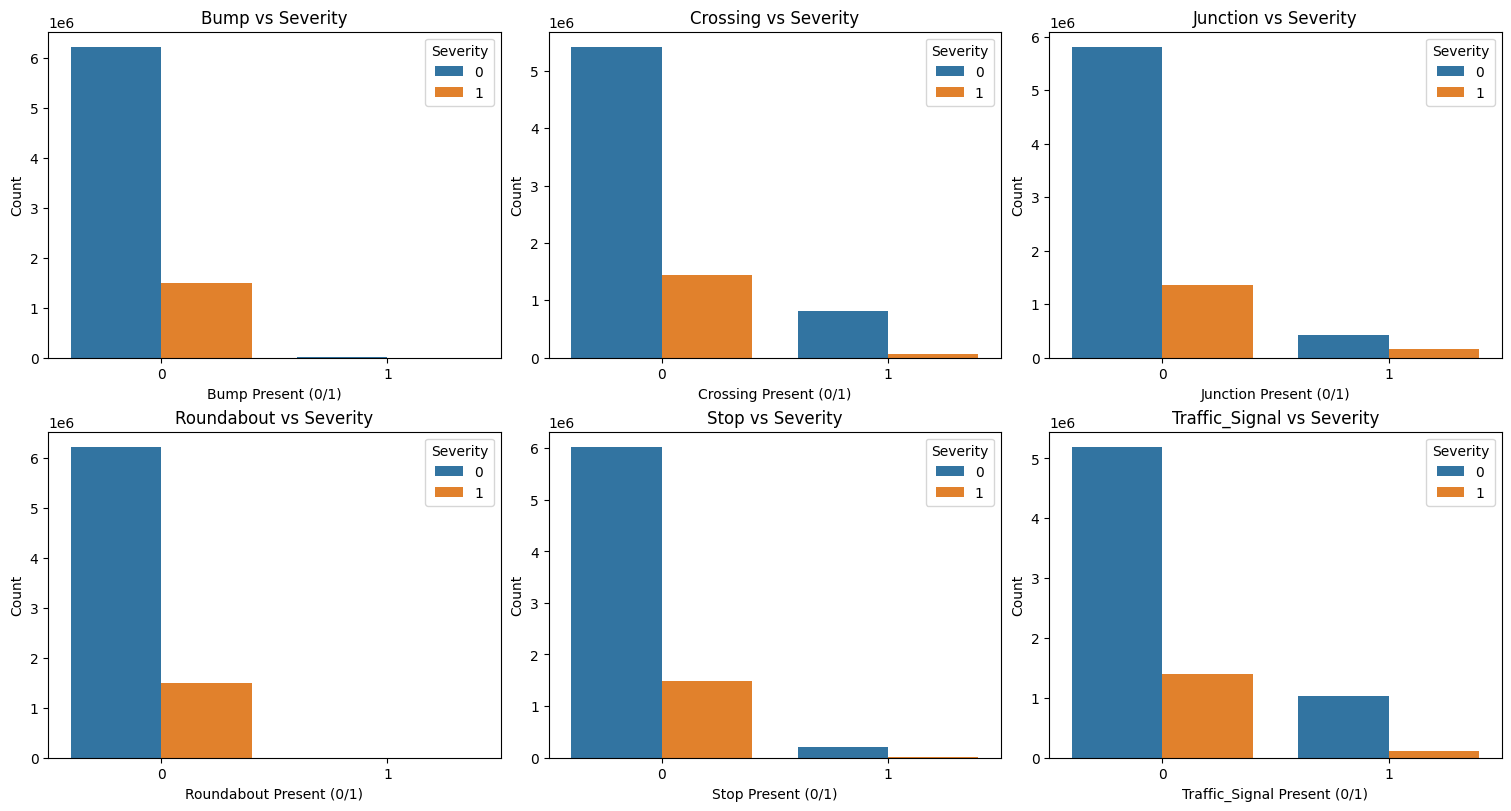

In [ ]:
binary_cols = ["Bump", "Crossing", "Junction", "Roundabout", "Stop", "Traffic_Signal"]

n = len(binary_cols)
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4), constrained_layout=True)
axes = axes.flatten()

for i, col in enumerate(binary_cols):
    sns.countplot(x=col, hue="Severity_binary", data=df, ax=axes[i])
    axes[i].set_title(f"{col} vs Severity")
    axes[i].set_xlabel(f"{col} Present (0/1)")
    axes[i].set_ylabel("Count")
    axes[i].legend(title="Severity", loc="upper right")

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

The distribution of accidents across infrastructure-related features shows that most accidents occur in the absence of specific road elements such as bumps, crossings, roundabouts, or traffic signals. This is largely explained by their lower prevalence in the road network, rather than by a direct effect on accident severity.


To examine linear relationships between numerical variables, a correlation matrix was computed.


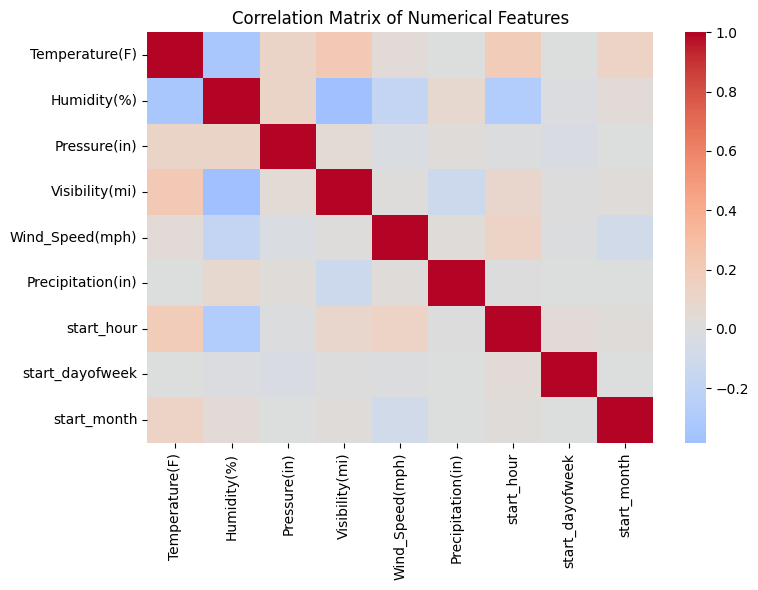

In [47]:
plt.figure(figsize=(8,6))
sns.heatmap(
    df[[
        "Temperature(F)", "Humidity(%)", "Pressure(in)",
        "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)",
        "start_hour", "start_dayofweek", "start_month"
    ]].corr(),
    cmap="coolwarm",
    center=0
)
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.show()


No strong linear association with accident severity is observed, indicating that severity is likely influenced by complex interactions rather than individual numerical factors.


# Data Preprocessing and Feature Engineering
Due to the large size of the original dataset, a representative random subset was selected to enable efficient exploratory analysis and model development while preserving the original class distribution.


In [ ]:
df_small = df.sample(2000000, random_state=42)
df_small["Severity_binary"].value_counts()
df_small.to_csv("US_Accidents_Preprocessed.csv", index=False)

Severity_binary
0    1609886
1     390114
Name: count, dtype: int64

In [ ]:
df = pd.read_csv("US_Accidents_Preprocessed.csv")
df = df.copy()

In [38]:
target = "Severity_binary"
y = df[target].astype("int8")

To reduce geographical granularity and avoid overfitting to state-level information, U.S. states were grouped into broader census-based regions.


In [39]:
northeast = {"CT","ME","MA","NH","RI","VT","NJ","NY","PA"}
midwest   = {"IL","IN","MI","OH","WI","IA","KS","MN","MO","NE","ND","SD"}
south     = {"DE","FL","GA","MD","NC","SC","VA","DC","WV","AL","KY","MS","TN","AR","LA","OK","TX"}
west      = {"AZ","CO","ID","MT","NV","NM","UT","WY","AK","CA","HI","OR","WA"}

def state_to_region(s):
    if pd.isna(s):
        return "Unknown"
    s = str(s).strip().upper()
    if s in northeast: return "Northeast"
    if s in midwest:   return "Midwest"
    if s in south:     return "South"
    if s in west:      return "West"
    return "Other"

df["Region"] = df["State"].apply(state_to_region)
df["Region"].value_counts()


Region
South        883378
West         637697
Northeast    244980
Midwest      233945
Name: count, dtype: int64

Detailed weather descriptions were consolidated into a smaller set of interpretable weather categories to reduce sparsity and improve model robustness.


In [40]:
def weather_to_group(w):
    if pd.isna(w):
        return "Unknown"
    w = str(w).lower()

    if "snow" in w or "sleet" in w or "ice" in w or "hail" in w or "freez" in w:
        return "Snow/Ice"
    if "fog" in w or "mist" in w or "haze" in w or "smoke" in w:
        return "Fog/Haze"
    if "thunder" in w or "t-storm" in w or "storm" in w:
        return "Storm"
    if "rain" in w or "drizzle" in w or "shower" in w:
        return "Rain"
    if "wind" in w or "breez" in w:
        return "Wind"
    if "clear" in w or "fair" in w:
        return "Clear"
    if "cloud" in w or "overcast" in w:
        return "Cloudy"
    return "Other"

df["Weather_Group"] = df["Weather_Condition"].apply(weather_to_group)
df["Weather_Group"].value_counts().head(10)


Weather_Group
Clear       872027
Cloudy      806583
Rain        132470
Fog/Haze     52396
Unknown      45044
Snow/Ice     43561
Storm        23072
Wind         20787
Other         4060
Name: count, dtype: int64

In [41]:
X = df.drop(columns=[target, "State", "Weather_Condition"]).copy()
X = X.replace({pd.NA: np.nan})
X.shape


(2000000, 18)

Numerical and categorical features were processed using a unified preprocessing pipeline, where numerical variables were imputed using the median and standardized, while categorical variables were imputed using the most frequent category and encoded via one-hot encoding.


In [ ]:
numeric_features = [
    "Temperature(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)",
    "Wind_Speed(mph)", "Precipitation(in)",
    "start_hour", "start_dayofweek", "start_month"
]

binary_features = [
    "Bump", "Crossing", "Junction", "Roundabout", "Stop", "Traffic_Signal"
]

categorical_features = ["Region", "Weather_Group", "Sunrise_Sunset"]

for c in categorical_features:
    X[c] = X[c].astype("object")

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

binary_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])


preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("bin", binary_transformer, binary_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)



The dataset was split into training and testing sets using a stratified approach to preserve the original class distribution, and the preprocessing pipeline was applied consistently to both sets.


In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)
print("Train class balance:\n", y_train.value_counts(normalize=True))
print("Test class balance:\n", y_test.value_counts(normalize=True))

X_train_ready = preprocess.fit_transform(X_train)
X_test_ready = preprocess.transform(X_test)

feature_names = preprocess.get_feature_names_out()
feature_names = np.array([n.split("__")[-1] for n in feature_names])

print("X_train_ready shape:", X_train_ready.shape)
print("X_test_ready shape:", X_test_ready.shape)


Train size: (1600000, 18)  Test size: (400000, 18)
Train class balance:
 Severity_binary
0    0.804943
1    0.195057
Name: proportion, dtype: float64
Test class balance:
 Severity_binary
0    0.804943
1    0.195057
Name: proportion, dtype: float64
X_train_ready shape: (1600000, 30)
X_test_ready shape: (400000, 30)


# Modeling and Evaluation


In this section, supervised machine learning models are trained and evaluated to predict accident severity. A Logistic Regression model is first used as a baseline to establish a reference performance under class imbalance. Subsequently, Random Forest classifiers are explored due to their ability to capture non-linear relationships and feature interactions. Given the strong class imbalance observed in the target variable, several imbalance-aware strategies are applied and compared, with particular emphasis on recall for severe accidents.

Model performance is evaluated using precision, recall, F1-score, and confusion matrices, with recall for the severe accident class treated as a key metric due to the safety-critical nature of the problem.


## LogisticRegression

In [44]:
baseline_model = LogisticRegression(
    max_iter=1000,
    n_jobs=-1
)

baseline_model.fit(X_train_ready, y_train)

y_pred = baseline_model.predict(X_test_ready)


print("Classification report (BASELINE):\n")
print(classification_report(y_test, y_pred, digits=3))

print("Confusion matrix:\n")
print(confusion_matrix(y_test, y_pred))


Classification report (BASELINE):

              precision    recall  f1-score   support

           0      0.805     1.000     0.892    321977
           1      0.245     0.000     0.000     78023

    accuracy                          0.805    400000
   macro avg      0.525     0.500     0.446    400000
weighted avg      0.696     0.805     0.718    400000

Confusion matrix:

[[321937     40]
 [ 78010     13]]


The Logistic Regression baseline achieves high overall accuracy; however, this performance is driven almost entirely by the majority class. The model fails to correctly identify severe accidents, exhibiting near-zero recall for the severe class. This behaviour highlights the limitations of standard classification approaches under strong class imbalance and demonstrates that accuracy alone is not an adequate metric for this problem.


## Random Forest (Standard)

In [45]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,          
    min_samples_leaf=50,   
    n_jobs=-1,
    random_state=42
)

rf_model.fit(X_train_ready, y_train)

y_pred_rf = rf_model.predict(X_test_ready)

print("Classification report (Random Forest):\n")
print(classification_report(y_test, y_pred_rf, digits=3))

print("Confusion matrix:\n")
print(confusion_matrix(y_test, y_pred_rf))


Classification report (Random Forest):

              precision    recall  f1-score   support

           0      0.809     0.997     0.893    321977
           1      0.665     0.027     0.052     78023

    accuracy                          0.808    400000
   macro avg      0.737     0.512     0.473    400000
weighted avg      0.781     0.808     0.729    400000

Confusion matrix:

[[320911   1066]
 [ 75905   2118]]


The standard Random Forest model slightly improves the detection of severe accidents compared to the Logistic Regression baseline. However, recall for the severe class remains very low, indicating that the model is still heavily biased toward the majority class. Despite capturing non-linear relationships, the Random Forest alone is insufficient to address the strong class imbalance present in the data.


## Random Forest + class_weight

In [47]:
rf_weighted = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_leaf=50,
    class_weight="balanced",   
    n_jobs=-1,
    random_state=42
)

rf_weighted.fit(X_train_ready, y_train)

y_pred_rf_w = rf_weighted.predict(X_test_ready)

print("Classification report (Random Forest + class_weight):\n")
print(classification_report(y_test, y_pred_rf_w, digits=3))

print("Confusion matrix:\n")
print(confusion_matrix(y_test, y_pred_rf_w))


Classification report (Random Forest + class_weight):

              precision    recall  f1-score   support

           0      0.907     0.627     0.741    321977
           1      0.323     0.735     0.449     78023

    accuracy                          0.648    400000
   macro avg      0.615     0.681     0.595    400000
weighted avg      0.793     0.648     0.684    400000

Confusion matrix:

[[201766 120211]
 [ 20646  57377]]


Introducing class weights in the Random Forest leads to a substantial increase in recall for the severe accident class, reaching approximately 73.5\%. This demonstrates that the model becomes significantly more sensitive to severe accidents when class imbalance is explicitly addressed. However, this improvement comes at the cost of reduced overall accuracy and lower precision, reflecting a higher number of false positive predictions for severe accidents.


## Random Forest + SMOTE

In [48]:
smote = SMOTE(random_state=42)

X_train_sm, y_train_sm = smote.fit_resample(X_train_ready, y_train)

print("After SMOTE (train) class balance:")
print(y_train_sm.value_counts(normalize=True))


rf_smote = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_leaf=50,
    n_jobs=-1,
    random_state=42
)

rf_smote.fit(X_train_sm, y_train_sm)


y_pred_rf_smote = rf_smote.predict(X_test_ready)

print("\nClassification report (Random Forest + SMOTE):\n")
print(classification_report(y_test, y_pred_rf_smote, digits=3))

print("Confusion matrix:\n")
print(confusion_matrix(y_test, y_pred_rf_smote))


After SMOTE (train) class balance:
Severity_binary
0    0.5
1    0.5
Name: proportion, dtype: float64

Classification report (Random Forest + SMOTE):

              precision    recall  f1-score   support

           0      0.888     0.703     0.785    321977
           1      0.342     0.635     0.444     78023

    accuracy                          0.690    400000
   macro avg      0.615     0.669     0.615    400000
weighted avg      0.782     0.690     0.719    400000

Confusion matrix:

[[226498  95479]
 [ 28451  49572]]


Applying SMOTE results in a balanced training set, enabling the Random Forest model to better learn patterns associated with severe accidents. Compared to the standard Random Forest, recall for the severe class increases substantially to approximately 63\%, while maintaining moderate precision. Although recall is lower than in the class-weighted model, SMOTE achieves a more balanced trade-off between sensitivity to severe accidents, precision, and overall accuracy.


## Random Forest + UnderSampling

In [49]:
rus = RandomUnderSampler(random_state=42)

X_train_rus, y_train_rus = rus.fit_resample(X_train_ready, y_train)

print("After RandomUnderSampler (train) class balance:")
print(y_train_rus.value_counts(normalize=True))


rf_rus = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_leaf=50,
    n_jobs=-1,
    random_state=42
)

rf_rus.fit(X_train_rus, y_train_rus)

y_pred_rf_rus = rf_rus.predict(X_test_ready)

print("\nClassification report (Random Forest + UnderSampling):\n")
print(classification_report(y_test, y_pred_rf_rus, digits=3))

print("Confusion matrix:\n")
print(confusion_matrix(y_test, y_pred_rf_rus))


After RandomUnderSampler (train) class balance:
Severity_binary
0    0.5
1    0.5
Name: proportion, dtype: float64

Classification report (Random Forest + UnderSampling):

              precision    recall  f1-score   support

           0      0.908     0.612     0.731    321977
           1      0.317     0.745     0.445     78023

    accuracy                          0.638    400000
   macro avg      0.613     0.678     0.588    400000
weighted avg      0.793     0.638     0.675    400000

Confusion matrix:

[[196905 125072]
 [ 19882  58141]]


Applying random undersampling produces a balanced training set and significantly increases recall for the severe accident class to approximately 74.5\%. This indicates a strong improvement in the model’s ability to detect severe accidents. However, this gain comes at the expense of lower precision and reduced overall accuracy, reflecting the information loss introduced by removing a large portion of majority-class samples.


## Random Forest + OverSampling

In [50]:
ros = RandomOverSampler(random_state=42)

X_train_ros, y_train_ros = ros.fit_resample(X_train_ready, y_train)

print("After RandomOverSampler (train) class balance:")
print(y_train_ros.value_counts(normalize=True))

rf_ros = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_leaf=50,
    n_jobs=-1,
    random_state=42
)

rf_ros.fit(X_train_ros, y_train_ros)

y_pred_rf_ros = rf_ros.predict(X_test_ready)

print("\nClassification report (Random Forest + OverSampling):\n")
print(classification_report(y_test, y_pred_rf_ros, digits=3))

print("Confusion matrix:\n")
print(confusion_matrix(y_test, y_pred_rf_ros))


After RandomOverSampler (train) class balance:
Severity_binary
0    0.5
1    0.5
Name: proportion, dtype: float64

Classification report (Random Forest + OverSampling):

              precision    recall  f1-score   support

           0      0.908     0.624     0.740    321977
           1      0.323     0.740     0.450     78023

    accuracy                          0.647    400000
   macro avg      0.616     0.682     0.595    400000
weighted avg      0.794     0.647     0.683    400000

Confusion matrix:

[[200917 121060]
 [ 20256  57767]]


Random oversampling balances the training data by replicating minority-class samples, resulting in a substantial increase in recall for the severe accident class to approximately 74\%. Similar to undersampling and class weighting, this approach significantly improves sensitivity to severe accidents but leads to reduced precision and overall accuracy due to an increase in false positive predictions.


### Model Comparison and Social Impact

The comparison of all evaluated models highlights the limitations of accuracy-driven approaches in the presence of strong class imbalance. Baseline models achieve high accuracy but largely fail to identify severe accidents, making them inadequate for safety-critical applications.

Imbalance-aware strategies significantly improve recall for severe accidents, albeit at the cost of reduced accuracy and precision. From a road safety perspective, this trade-off is justified, as failing to detect a severe accident carries a higher social cost than incorrectly flagging a non-severe one. Prioritizing recall therefore enables more meaningful and actionable predictions to support targeted safety interventions.


# Explainability Analysis

While predictive performance is essential, the applicability of machine learning models in road safety contexts also depends on their interpretability. In safety-critical domains, understanding why a model predicts a severe accident is as important as the prediction itself, particularly when such models may inform policy decisions or targeted interventions.

To address this requirement, explainability techniques are applied to interpret both global model behaviour and individual predictions. In this section, SHAP and LIME are used to analyze how temporal, environmental, and infrastructural features contribute to accident severity predictions, providing transparency and supporting trust in the proposed models.


## SHAP Analysis

SHAP was applied to interpret the predictions of the Random Forest model trained with oversampling, enabling both global and local explanations of accident severity predictions. This approach allows us to understand how different features contribute to the model’s decisions, which is particularly important in road safety contexts where transparency and accountability are essential.

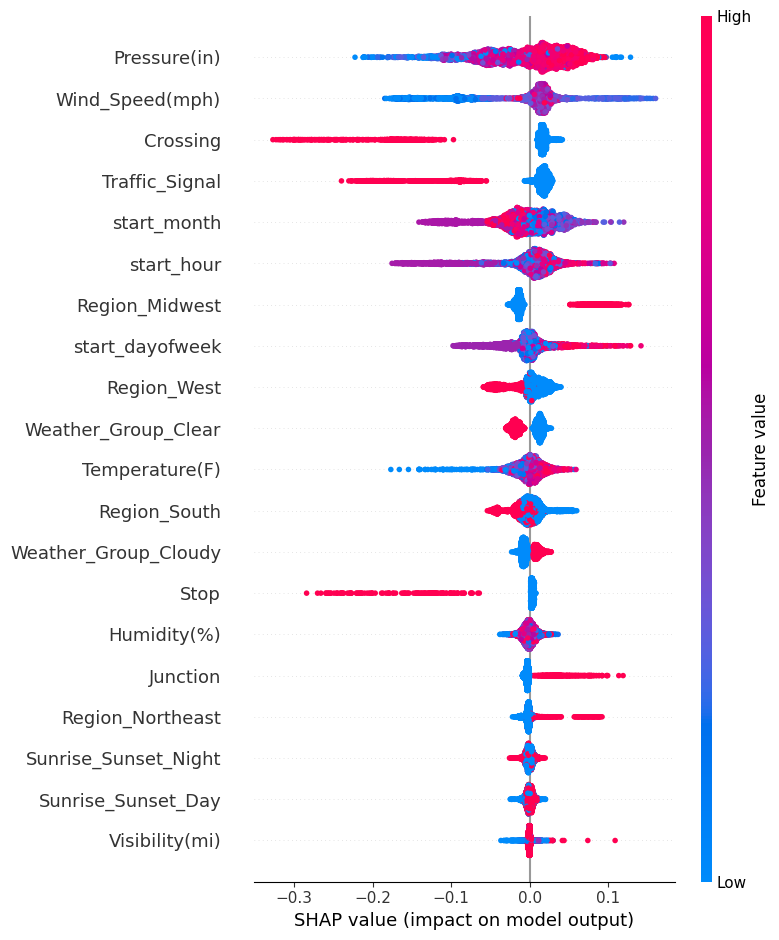

In [ ]:
X_shap = X_train.sample(5000, random_state=42)

X_shap_ready = preprocess.transform(X_shap)

if hasattr(X_shap_ready, "toarray"):
    X_shap_ready = X_shap_ready.toarray()

X_shap_ready = X_shap_ready.astype(np.float32)

feature_names = preprocess.get_feature_names_out()
feature_names = np.array([n.split("__")[-1] for n in feature_names])

explainer = shap.TreeExplainer(rf_rus)
sv = explainer.shap_values(X_shap_ready, check_additivity=False, approximate=True)

if isinstance(sv, list):
    sv1 = sv[1]
elif sv.ndim == 3:
    sv1 = sv[:, :, 1]
else:
    sv1 = sv

if sv1.shape[1] == X_shap_ready.shape[1] + 1:
    sv1 = sv1[:, :-1]

shap.summary_plot(
    sv1,
    features=X_shap_ready,
    feature_names=feature_names,
    show=True
)

At the global level, the SHAP summary plot shows that a combination of environmental, temporal, and infrastructural variables has the strongest influence on the prediction of severe accidents. Atmospheric pressure, wind speed, and temporal features such as month and hour of the day emerge as key contributors, indicating that weather conditions and time-related factors play an important role in accident severity. Infrastructure-related features, including the presence of crossings and traffic signals, also appear among the most influential variables, highlighting the relevance of road design and traffic control elements.

From a real-world perspective, these findings suggest that severe accidents are not driven by a single factor, but rather by the interaction of environmental conditions, traffic timing, and infrastructure context. For example, locations without adequate traffic control elements or during periods of higher traffic demand may require increased monitoring, improved signage, or stricter speed control measures. Similarly, adverse weather conditions combined with specific temporal patterns may justify adaptive safety interventions such as dynamic speed limits or targeted warnings.

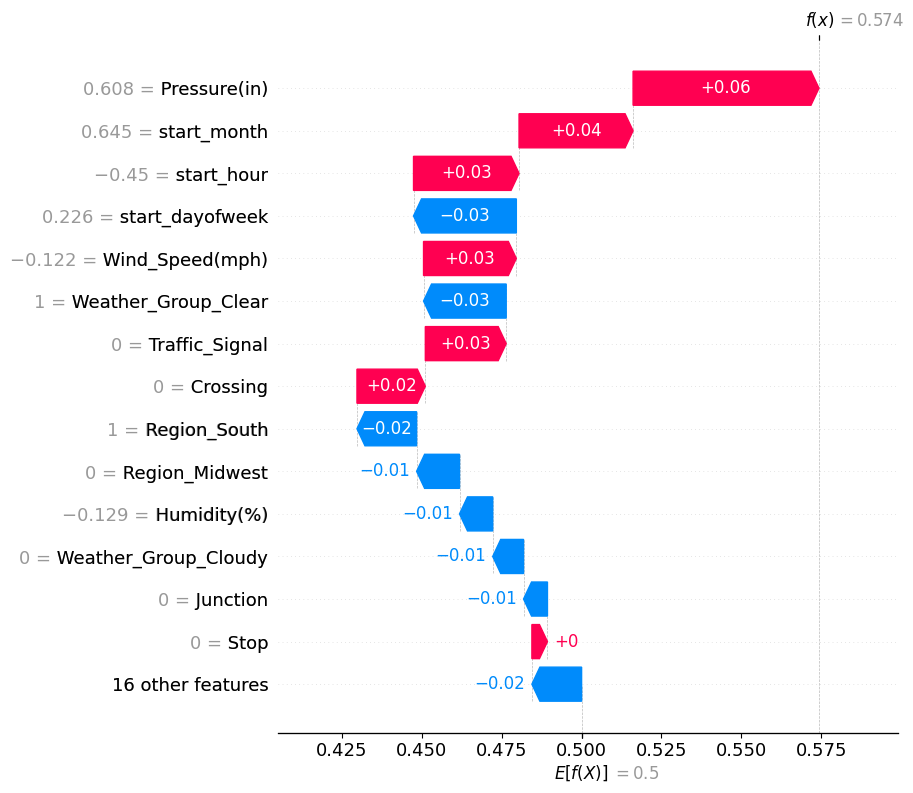

In [ ]:
i = 0 

exp = shap.Explanation(
    values=sv1[i],
    base_values=explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value,
    data=X_shap_ready[i],
    feature_names=feature_names
)

shap.plots.waterfall(exp, max_display=15)

At the local level, the SHAP waterfall plot illustrates how individual features contribute to a specific severe accident prediction. Starting from the baseline probability, the prediction is increased by factors such as pressure, wind speed, and temporal variables, while other features partially counterbalance this effect. This local explanation demonstrates how SHAP provides transparent, additive reasoning for individual predictions, allowing practitioners to understand why a particular accident is classified as severe.

Overall, SHAP enhances trust in the predictive model by making its decision process interpretable. In a road safety setting, such transparency is crucial for supporting data-driven policy decisions, identifying high-risk scenarios, and guiding targeted interventions aimed at reducing the social and economic impact of severe road accidents.

## LIME Analysis

LIME was applied to provide a local, instance-level explanation of the model’s predictions, complementing the global insights obtained with SHAP.


In [ ]:
model = rf_rus   

idx = 0
x_raw = X_test.iloc[idx:idx+1]
y_true = int(y_test.iloc[idx]) if hasattr(y_test, "iloc") else int(y_test[idx])

x_ready = preprocess.transform(x_raw)
if hasattr(x_ready, "toarray"):
    x_ready = x_ready.toarray()
x_ready = x_ready.astype(np.float32)

X_lime_ref = preprocess.transform(X_train.sample(2000, random_state=42))
if hasattr(X_lime_ref, "toarray"):
    X_lime_ref = X_lime_ref.toarray()
X_lime_ref = X_lime_ref.astype(np.float32)

feature_names = preprocess.get_feature_names_out()
feature_names = np.array([n.split("__")[-1] for n in feature_names])
class_names = ["0", "1"]  # 0=não grave, 1=grave

explainer = LimeTabularExplainer(
    training_data=X_lime_ref,
    feature_names=feature_names,
    class_names=class_names,
    mode="classification",
    discretize_continuous=True
)

predict_fn = lambda X: model.predict_proba(X)

exp = explainer.explain_instance(
    data_row=x_ready[0],
    predict_fn=predict_fn,
    num_features=15
)

print("y_true:", y_true)
print("pred_proba:", model.predict_proba(x_ready)[0])


display(HTML(exp.as_html()))


y_true: 1
pred_proba: [0.28616335 0.71383665]


For the selected test instance, the Random Forest model trained with oversampling correctly predicts a severe accident with a probability of approximately 0.71. The LIME explanation shows that the prediction is driven by a combination of infrastructural, regional, and weather-related factors, illustrating how local conditions can jointly create high-risk scenarios that may require targeted safety interventions.


The use of SHAP and LIME demonstrates that explainable machine learning can play a meaningful role in road safety analysis. By identifying how environmental conditions, temporal patterns, and infrastructural characteristics contribute to accident severity, these methods help translate model predictions into actionable insights. From a social perspective, such transparency supports informed decision-making, enabling authorities to prioritize high-risk scenarios, improve traffic control measures, and design targeted interventions aimed at reducing the impact of severe road accidents.


# Conclusion

This study shows that predicting accident severity requires more than high overall accuracy, particularly in the presence of strong class imbalance. Models that prioritize recall for severe accidents, even at the cost of reduced accuracy, are more aligned with real-world road safety objectives. By combining imbalance-aware learning with explainable methods, this work highlights how data-driven approaches can support safer transportation systems, contribute to risk-aware planning, and ultimately help mitigate the social and economic consequences of severe traffic accidents.
